# Лабораторная работа №3: Решающее дерево (Decision Tree)

## Цель работы

Познакомиться с алгоритмом решающего дерева для задач классификации и регрессии, реализовать его с помощью библиотеки scikit-learn и самостоятельно на Python/NumPy.

## Используемые датасеты

### 1. Credit Card Fraud Detection (Классификация)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- **Задача**: Обнаружение мошеннических транзакций по кредитным картам
- **Метод**: Decision Tree Classifier
- **Практическое применение**: Финансовая безопасность
- **Особенности**: Сильно несбалансированный датасет (fraud ~0.17%)

### 2. Student Performance Dataset (Регрессия)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/larsen0966/student-performance-data-set)
- **Задача**: Предсказание итоговой оценки студента (G3)
- **Метод**: Decision Tree Regressor
- **Практическое применение**: Образовательная аналитика
- **Особенности**: Смешанные типы признаков

## Выбор метрик

### Классификация (Decision Tree)
- **ROC-AUC Score**: Основная метрика для несбалансированных данных
- **Precision**: Точность (минимизация ложных срабатываний)
- **Recall**: Полнота (обнаружение максимума мошенничеств)
- **F1-Score**: Гармоническое среднее Precision и Recall

### Регрессия (Decision Tree)
- **R² Score**: Коэффициент детерминации (доля объясненной дисперсии)
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка
- **RMSE (Root Mean Squared Error)**: Корень из средней квадратичной ошибки

## Особенности решающих деревьев

**Преимущества:**
- Не требуют масштабирования признаков
- Работают с нелинейными зависимостями
- Легко интерпретируемы
- Могут работать с категориальными признаками

**Недостатки:**
- Склонны к переобучению
- Нестабильны (малое изменение данных → разное дерево)
- Могут создавать несбалансированные деревья

## 1. Импорт библиотек

Импортируем все необходимые библиотеки для работы с данными, построения деревьев решений и визуализации.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn для моделей и метрик
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    r2_score, mean_absolute_error, mean_squared_error
)

# Для работы с несбалансированными данными
from imblearn.under_sampling import RandomUnderSampler

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Фиксируем random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Библиотеки успешно загружены!")


✓ Библиотеки успешно загружены!


## 2. Загрузка и подготовка данных

Используем те же датасеты, что и в предыдущих лабораторных работах.

In [2]:
# Загрузка датасетов
df_fraud = pd.read_csv('data/creditcard.csv')
df_student = pd.read_csv('data/student-por.csv')

print("=" * 80)
print("ДАТАСЕТЫ ЗАГРУЖЕНЫ")
print("=" * 80)
print(f"Credit Card Fraud: {df_fraud.shape}")
print(f"Student Performance: {df_student.shape}")

# Подготовка данных для классификации (Fraud Detection)
X_fraud = df_fraud.drop('Class', axis=1)
y_fraud = df_fraud['Class']

# Балансировка классов
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)
X_fraud_balanced, y_fraud_balanced = rus.fit_resample(X_fraud, y_fraud)

# Разбиение на train/test для классификации
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_fraud_balanced, y_fraud_balanced,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_fraud_balanced
)

print(f"\nКлассификация (после балансировки): Train={X_train_clf.shape}, Test={X_test_clf.shape}")
print(f"Распределение классов (train): {pd.Series(y_train_clf).value_counts().to_dict()}")

# Подготовка данных для регрессии (Student Performance)
y_student = df_student['G3']
X_student = df_student.drop(['G3'], axis=1)

# Кодирование категориальных признаков
X_student_encoded = X_student.copy()
for col in X_student.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_student_encoded[col] = le.fit_transform(X_student[col].astype(str))

# Разбиение на train/test для регрессии
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_student_encoded, y_student,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"\nРегрессия: Train={X_train_reg.shape}, Test={X_test_reg.shape}")
print(f"Целевая переменная - Mean: {y_train_reg.mean():.2f}, Std: {y_train_reg.std():.2f}")

ДАТАСЕТЫ ЗАГРУЖЕНЫ
Credit Card Fraud: (284807, 31)
Student Performance: (649, 33)

Классификация (после балансировки): Train=(2361, 30), Test=(591, 30)
Распределение классов (train): {0: 1967, 1: 394}

Регрессия: Train=(519, 32), Test=(130, 32)
Целевая переменная - Mean: 11.79, Std: 3.25


## 3. Бейзлайн (Baseline) - sklearn реализация

### 3.1 Decision Tree для классификации (Baseline)

Обучим базовое дерево решений с параметрами по умолчанию для детекции мошенничества.

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Decision Tree Classifier)
Accuracy:  0.9492
Precision: 0.8269
Recall:    0.8776
F1-Score:  0.8515
ROC-AUC:   0.9205

Глубина дерева: 19
Количество листьев: 68

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97       493
       Fraud       0.83      0.88      0.85        98

    accuracy                           0.95       591
   macro avg       0.90      0.92      0.91       591
weighted avg       0.95      0.95      0.95       591



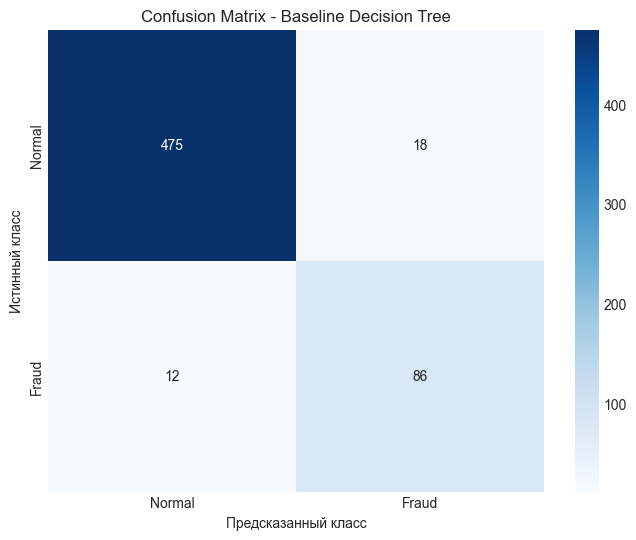

In [3]:
# Обучение базового Decision Tree для классификации
tree_clf_baseline = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_clf_baseline.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf_baseline = tree_clf_baseline.predict(X_test_clf)
y_pred_proba_clf_baseline = tree_clf_baseline.predict_proba(X_test_clf)[:, 1]

# Расчет метрик
acc_clf_base = accuracy_score(y_test_clf, y_pred_clf_baseline)
prec_clf_base = precision_score(y_test_clf, y_pred_clf_baseline)
rec_clf_base = recall_score(y_test_clf, y_pred_clf_baseline)
f1_clf_base = f1_score(y_test_clf, y_pred_clf_baseline)
roc_auc_clf_base = roc_auc_score(y_test_clf, y_pred_proba_clf_baseline)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Decision Tree Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_base:.4f}")
print(f"Precision: {prec_clf_base:.4f}")
print(f"Recall:    {rec_clf_base:.4f}")
print(f"F1-Score:  {f1_clf_base:.4f}")
print(f"ROC-AUC:   {roc_auc_clf_base:.4f}")

print(f"\nГлубина дерева: {tree_clf_baseline.get_depth()}")
print(f"Количество листьев: {tree_clf_baseline.get_n_leaves()}")

print("\n" + "=" * 80)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_clf_baseline, target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Baseline Decision Tree')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Сохраняем результаты
results_clf = {
    'Model': ['Baseline Tree'],
    'Accuracy': [acc_clf_base],
    'Precision': [prec_clf_base],
    'Recall': [rec_clf_base],
    'F1-Score': [f1_clf_base],
    'ROC-AUC': [roc_auc_clf_base]
}


### 3.2 Decision Tree для регрессии (Baseline)

Обучим базовое дерево решений для предсказания оценок студентов.

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Decision Tree Regressor)
R² Score: 0.6214
MAE:      0.8615
MSE:      3.6923
RMSE:     1.9215

Глубина дерева: 15
Количество листьев: 218


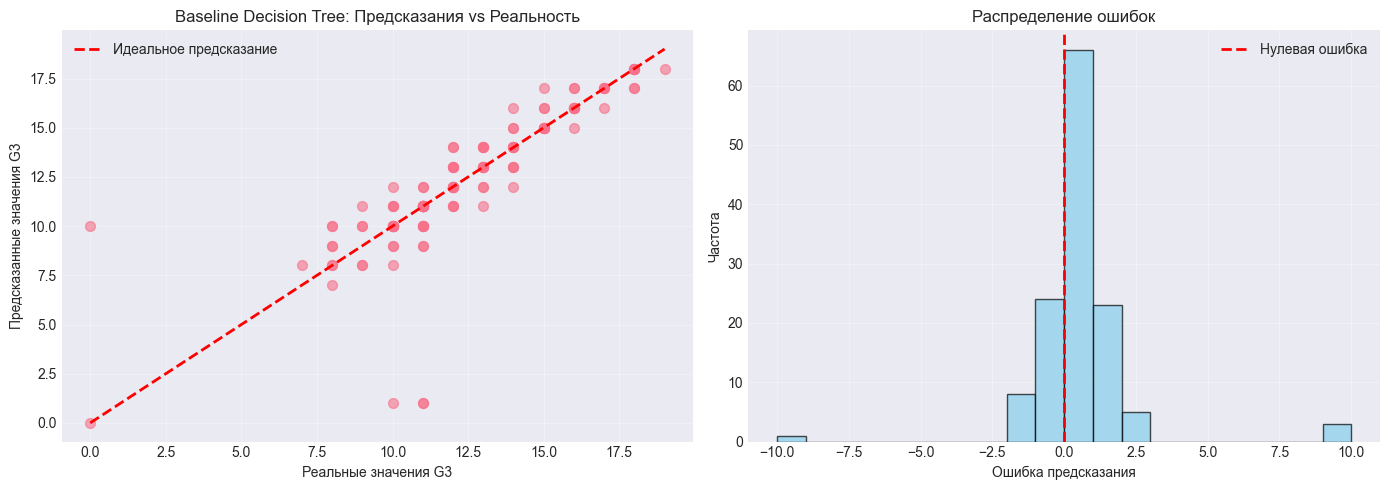

In [4]:
# Обучение базового Decision Tree для регрессии
tree_reg_baseline = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_reg_baseline.fit(X_train_reg, y_train_reg)

# Предсказания
y_pred_reg_baseline = tree_reg_baseline.predict(X_test_reg)

# Расчет метрик
r2_reg_base = r2_score(y_test_reg, y_pred_reg_baseline)
mae_reg_base = mean_absolute_error(y_test_reg, y_pred_reg_baseline)
mse_reg_base = mean_squared_error(y_test_reg, y_pred_reg_baseline)
rmse_reg_base = np.sqrt(mse_reg_base)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Decision Tree Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_base:.4f}")
print(f"MAE:      {mae_reg_base:.4f}")
print(f"MSE:      {mse_reg_base:.4f}")
print(f"RMSE:     {rmse_reg_base:.4f}")

print(f"\nГлубина дерева: {tree_reg_baseline.get_depth()}")
print(f"Количество листьев: {tree_reg_baseline.get_n_leaves()}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Предсказания vs Реальность
axes[0].scatter(y_test_reg, y_pred_reg_baseline, alpha=0.6, s=50)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
             [y_test_reg.min(), y_test_reg.max()],
             'r--', lw=2, label='Идеальное предсказание')
axes[0].set_xlabel('Реальные значения G3')
axes[0].set_ylabel('Предсказанные значения G3')
axes[0].set_title('Baseline Decision Tree: Предсказания vs Реальность')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Распределение ошибок
residuals = y_test_reg - y_pred_reg_baseline
axes[1].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Нулевая ошибка')
axes[1].set_xlabel('Ошибка предсказания')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сохраняем результаты
results_reg = {
    'Model': ['Baseline Tree'],
    'R²': [r2_reg_base],
    'MAE': [mae_reg_base],
    'MSE': [mse_reg_base],
    'RMSE': [rmse_reg_base]
}


## 4. Улучшенный бейзлайн (Improved Baseline)

### 4.1 Гипотезы для улучшения

**Для Decision Tree:**
1. **Ограничение глубины** (max_depth) - борьба с переобучением
2. **Минимальное количество сэмплов** для split (min_samples_split)
3. **Минимальное количество сэмплов** в листе (min_samples_leaf)
4. **Критерий разбиения**: gini vs entropy (для классификации), mse vs mae (для регрессии)
5. **Максимальное количество признаков** (max_features)

По умолчанию дерево растет до тех пор, пока все листья не станут "чистыми" → переобучение.

### 4.2 Улучшенный Decision Tree для классификации

In [5]:
# Параметры для GridSearch
param_grid_clf = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

print("Запуск GridSearchCV для Decision Tree Classifier...")
print(f"Тестируемые комбинации: {len(param_grid_clf['max_depth']) * len(param_grid_clf['min_samples_split']) * len(param_grid_clf['min_samples_leaf']) * len(param_grid_clf['criterion']) * len(param_grid_clf['max_features'])}")

# GridSearch
grid_clf = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid_clf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train_clf, y_train_clf)

print("\n" + "=" * 80)
print(f"Лучшие параметры: {grid_clf.best_params_}")
print(f"Лучший ROC-AUC (CV): {grid_clf.best_score_:.4f}")

# Используем лучшую модель
tree_clf_improved = grid_clf.best_estimator_

# Предсказания
y_pred_clf_improved = tree_clf_improved.predict(X_test_clf)
y_pred_proba_clf_improved = tree_clf_improved.predict_proba(X_test_clf)[:, 1]

# Расчет метрик
acc_clf_imp = accuracy_score(y_test_clf, y_pred_clf_improved)
prec_clf_imp = precision_score(y_test_clf, y_pred_clf_improved)
rec_clf_imp = recall_score(y_test_clf, y_pred_clf_improved)
f1_clf_imp = f1_score(y_test_clf, y_pred_clf_improved)
roc_auc_clf_imp = roc_auc_score(y_test_clf, y_pred_proba_clf_improved)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Decision Tree Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_imp:.4f}  (Δ = {acc_clf_imp - acc_clf_base:+.4f})")
print(f"Precision: {prec_clf_imp:.4f}  (Δ = {prec_clf_imp - prec_clf_base:+.4f})")
print(f"Recall:    {rec_clf_imp:.4f}  (Δ = {rec_clf_imp - rec_clf_base:+.4f})")
print(f"F1-Score:  {f1_clf_imp:.4f}  (Δ = {f1_clf_imp - f1_clf_base:+.4f})")
print(f"ROC-AUC:   {roc_auc_clf_imp:.4f}  (Δ = {roc_auc_clf_imp - roc_auc_clf_base:+.4f})")

print(f"\nГлубина дерева: {tree_clf_improved.get_depth()} (было: {tree_clf_baseline.get_depth()})")
print(f"Количество листьев: {tree_clf_improved.get_n_leaves()} (было: {tree_clf_baseline.get_n_leaves()})")

# Обновляем результаты
results_clf['Model'].append('Improved Tree')
results_clf['Accuracy'].append(acc_clf_imp)
results_clf['Precision'].append(prec_clf_imp)
results_clf['Recall'].append(rec_clf_imp)
results_clf['F1-Score'].append(f1_clf_imp)
results_clf['ROC-AUC'].append(roc_auc_clf_imp)


Запуск GridSearchCV для Decision Tree Classifier...
Тестируемые комбинации: 576
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Лучшие параметры: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20}
Лучший ROC-AUC (CV): 0.9583

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Decision Tree Classifier)
Accuracy:  0.9679  (Δ = +0.0186)
Precision: 0.9647  (Δ = +0.1378)
Recall:    0.8367  (Δ = -0.0408)
F1-Score:  0.8962  (Δ = +0.0447)
ROC-AUC:   0.9412  (Δ = +0.0206)

Глубина дерева: 5 (было: 19)
Количество листьев: 16 (было: 68)


### 4.3 Улучшенный Decision Tree для регрессии

In [6]:
# Параметры для GridSearch регрессора
param_grid_reg = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['squared_error', 'absolute_error'],
    'max_features': ['sqrt', 'log2', None]
}

print("Запуск GridSearchCV для Decision Tree Regressor...")
print(f"Тестируемые комбинации: {len(param_grid_reg['max_depth']) * len(param_grid_reg['min_samples_split']) * len(param_grid_reg['min_samples_leaf']) * len(param_grid_reg['criterion']) * len(param_grid_reg['max_features'])}")

# GridSearch
grid_reg = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_train_reg, y_train_reg)

print("\n" + "=" * 80)
print(f"Лучшие параметры: {grid_reg.best_params_}")
print(f"Лучший R² (CV): {grid_reg.best_score_:.4f}")

# Используем лучшую модель
tree_reg_improved = grid_reg.best_estimator_

# Предсказания
y_pred_reg_improved = tree_reg_improved.predict(X_test_reg)

# Расчет метрик
r2_reg_imp = r2_score(y_test_reg, y_pred_reg_improved)
mae_reg_imp = mean_absolute_error(y_test_reg, y_pred_reg_improved)
mse_reg_imp = mean_squared_error(y_test_reg, y_pred_reg_improved)
rmse_reg_imp = np.sqrt(mse_reg_imp)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Decision Tree Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_imp:.4f}  (Δ = {r2_reg_imp - r2_reg_base:+.4f})")
print(f"MAE:      {mae_reg_imp:.4f}  (Δ = {mae_reg_imp - mae_reg_base:+.4f})")
print(f"MSE:      {mse_reg_imp:.4f}  (Δ = {mse_reg_imp - mse_reg_base:+.4f})")
print(f"RMSE:     {rmse_reg_imp:.4f}  (Δ = {rmse_reg_imp - rmse_reg_base:+.4f})")

print(f"\nГлубина дерева: {tree_reg_improved.get_depth()} (было: {tree_reg_baseline.get_depth()})")
print(f"Количество листьев: {tree_reg_improved.get_n_leaves()} (было: {tree_reg_baseline.get_n_leaves()})")

# Обновляем результаты
results_reg['Model'].append('Improved Tree')
results_reg['R²'].append(r2_reg_imp)
results_reg['MAE'].append(mae_reg_imp)
results_reg['MSE'].append(mse_reg_imp)
results_reg['RMSE'].append(rmse_reg_imp)


Запуск GridSearchCV для Decision Tree Regressor...
Тестируемые комбинации: 576
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Лучшие параметры: {'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2}
Лучший R² (CV): 0.8395

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Decision Tree Regressor)
R² Score: 0.7891  (Δ = +0.1677)
MAE:      0.8555  (Δ = -0.0060)
MSE:      2.0565  (Δ = -1.6358)
RMSE:     1.4341  (Δ = -0.4875)

Глубина дерева: 5 (было: 15)
Количество листьев: 28 (было: 218)


## 5. Имплементация Decision Tree с нуля

### 5.1 Алгоритм построения дерева

**Основная идея:**
1. Для каждого признака находим лучшую точку разбиения
2. Выбираем признак и точку разбиения с наибольшим information gain
3. Разбиваем узел на два дочерних
4. Рекурсивно повторяем для дочерних узлов
5. Останавливаемся при достижении max_depth или min_samples_split

**Критерии качества разбиения:**
- Классификация: Gini impurity или Entropy
- Регрессия: MSE (Mean Squared Error)

### 5.2 Кастомный класс Decision Tree

In [7]:
class Node:
    """Узел дерева решений"""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Индекс признака для разбиения
        self.threshold = threshold  # Порог разбиения
        self.left = left           # Левое поддерево
        self.right = right         # Правое поддерево
        self.value = value         # Значение в листе (для предсказания)


class CustomDecisionTree:
    """
    Кастомная реализация дерева решений.
    Поддерживает как классификацию, так и регрессию.
    """
    
    def __init__(self, task='classification', max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, criterion='gini'):
        """
        Параметры:
        -----------
        task : str
            'classification' или 'regression'
        max_depth : int or None
            Максимальная глубина дерева
        min_samples_split : int
            Минимальное количество сэмплов для разбиения узла
        min_samples_leaf : int
            Минимальное количество сэмплов в листе
        criterion : str
            Критерий разбиения: 'gini', 'entropy' (для классификации), 
            'mse' (для регрессии)
        """
        self.task = task
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.root = None
        self.n_classes = None
        
    def _gini(self, y):
        """Вычисление Gini impurity"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    
    def _entropy(self, y):
        """Вычисление Entropy"""
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities + 1e-10))
    
    def _mse(self, y):
        """Вычисление Mean Squared Error"""
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)
    
    def _calculate_impurity(self, y):
        """Вычисление impurity в зависимости от критерия"""
        if self.task == 'classification':
            if self.criterion == 'gini':
                return self._gini(y)
            else:  # entropy
                return self._entropy(y)
        else:  # regression
            return self._mse(y)
    
    def _information_gain(self, y, y_left, y_right):
        """Вычисление information gain от разбиения"""
        n = len(y)
        n_left, n_right = len(y_left), len(y_right)
        
        if n_left == 0 or n_right == 0:
            return 0
        
        impurity_before = self._calculate_impurity(y)
        impurity_after = (n_left / n) * self._calculate_impurity(y_left) + \
                        (n_right / n) * self._calculate_impurity(y_right)
        
        return impurity_before - impurity_after
    
    def _best_split(self, X, y):
        """Поиск лучшего разбиения"""
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Разбиение
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                # Проверка min_samples_leaf
                if np.sum(left_mask) < self.min_samples_leaf or \
                   np.sum(right_mask) < self.min_samples_leaf:
                    continue
                
                y_left, y_right = y[left_mask], y[right_mask]
                
                # Вычисление information gain
                gain = self._information_gain(y, y_left, y_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Рекурсивное построение дерева"""
        n_samples = len(y)
        
        # Условия остановки
        if depth == self.max_depth or \
           n_samples < self.min_samples_split or \
           len(np.unique(y)) == 1:
            # Создаем лист
            if self.task == 'classification':
                # Наиболее частый класс
                value = np.bincount(y.astype(int)).argmax()
            else:
                # Среднее значение
                value = np.mean(y)
            return Node(value=value)
        
        # Поиск лучшего разбиения
        feature, threshold, gain = self._best_split(X, y)
        
        if feature is None or gain == 0:
            # Не можем найти хорошее разбиение → создаем лист
            if self.task == 'classification':
                value = np.bincount(y.astype(int)).argmax()
            else:
                value = np.mean(y)
            return Node(value=value)
        
        # Разбиение данных
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        
        # Рекурсивное построение поддеревьев
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(feature=feature, threshold=threshold, 
                   left=left_subtree, right=right_subtree)
    
    def fit(self, X, y):
        """Обучение дерева"""
        X = np.array(X)
        y = np.array(y)
        
        if self.task == 'classification':
            self.n_classes = len(np.unique(y))
        
        self.root = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, node):
        """Предсказание для одного образца"""
        if node.value is not None:
            # Достигли листа
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        """Предсказание для всех образцов"""
        X = np.array(X)
        return np.array([self._predict_sample(x, self.root) for x in X])
    
    def _predict_proba_sample(self, x, node):
        """Предсказание вероятностей для одного образца (только классификация)"""
        if node.value is not None:
            # Лист - возвращаем one-hot encoding
            proba = np.zeros(self.n_classes)
            proba[int(node.value)] = 1.0
            return proba
        
        if x[node.feature] <= node.threshold:
            return self._predict_proba_sample(x, node.left)
        else:
            return self._predict_proba_sample(x, node.right)
    
    def predict_proba(self, X):
        """Предсказание вероятностей (только для классификации)"""
        if self.task != 'classification':
            raise ValueError("predict_proba доступен только для классификации")
        
        X = np.array(X)
        return np.array([self._predict_proba_sample(x, self.root) for x in X])

print("✓ Класс CustomDecisionTree создан!")


✓ Класс CustomDecisionTree создан!


In [8]:
# Обучение кастомного дерева для классификации
# Используем те же параметры, что и у лучшей sklearn модели
custom_tree_clf = CustomDecisionTree(
    task='classification',
    max_depth=tree_clf_improved.max_depth,
    min_samples_split=tree_clf_improved.min_samples_split,
    min_samples_leaf=tree_clf_improved.min_samples_leaf,
    criterion='gini'
)

print("Обучение кастомного Decision Tree (классификация)...")
custom_tree_clf.fit(X_train_clf.values, y_train_clf.values)

# Предсказания
y_pred_clf_custom = custom_tree_clf.predict(X_test_clf.values)
y_pred_proba_clf_custom = custom_tree_clf.predict_proba(X_test_clf.values)[:, 1]

# Расчет метрик
acc_clf_custom = accuracy_score(y_test_clf, y_pred_clf_custom)
prec_clf_custom = precision_score(y_test_clf, y_pred_clf_custom)
rec_clf_custom = recall_score(y_test_clf, y_pred_clf_custom)
f1_clf_custom = f1_score(y_test_clf, y_pred_clf_custom)
roc_auc_clf_custom = roc_auc_score(y_test_clf, y_pred_proba_clf_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Decision Tree Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_custom:.4f}")
print(f"Precision: {prec_clf_custom:.4f}")
print(f"Recall:    {rec_clf_custom:.4f}")
print(f"F1-Score:  {f1_clf_custom:.4f}")
print(f"ROC-AUC:   {roc_auc_clf_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN (Improved):")
print("=" * 80)
print(f"Accuracy:  sklearn = {acc_clf_imp:.4f}, custom = {acc_clf_custom:.4f}, Δ = {acc_clf_custom - acc_clf_imp:+.4f}")
print(f"ROC-AUC:   sklearn = {roc_auc_clf_imp:.4f}, custom = {roc_auc_clf_custom:.4f}, Δ = {roc_auc_clf_custom - roc_auc_clf_imp:+.4f}")

# Обновляем результаты
results_clf['Model'].append('Custom Tree')
results_clf['Accuracy'].append(acc_clf_custom)
results_clf['Precision'].append(prec_clf_custom)
results_clf['Recall'].append(rec_clf_custom)
results_clf['F1-Score'].append(f1_clf_custom)
results_clf['ROC-AUC'].append(roc_auc_clf_custom)


Обучение кастомного Decision Tree (классификация)...

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Decision Tree Classifier)
Accuracy:  0.9594
Precision: 0.8936
Recall:    0.8571
F1-Score:  0.8750
ROC-AUC:   0.9184

СРАВНЕНИЕ С SKLEARN (Improved):
Accuracy:  sklearn = 0.9679, custom = 0.9594, Δ = -0.0085
ROC-AUC:   sklearn = 0.9412, custom = 0.9184, Δ = -0.0227


### 5.4 Тестирование кастомного дерева для регрессии

In [9]:
# Обучение кастомного дерева для регрессии
custom_tree_reg = CustomDecisionTree(
    task='regression',
    max_depth=tree_reg_improved.max_depth,
    min_samples_split=tree_reg_improved.min_samples_split,
    min_samples_leaf=tree_reg_improved.min_samples_leaf,
    criterion='mse'
)

print("Обучение кастомного Decision Tree (регрессия)...")
custom_tree_reg.fit(X_train_reg.values, y_train_reg.values)

# Предсказания
y_pred_reg_custom = custom_tree_reg.predict(X_test_reg.values)

# Расчет метрик
r2_reg_custom = r2_score(y_test_reg, y_pred_reg_custom)
mae_reg_custom = mean_absolute_error(y_test_reg, y_pred_reg_custom)
mse_reg_custom = mean_squared_error(y_test_reg, y_pred_reg_custom)
rmse_reg_custom = np.sqrt(mse_reg_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Decision Tree Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_custom:.4f}")
print(f"MAE:      {mae_reg_custom:.4f}")
print(f"MSE:      {mse_reg_custom:.4f}")
print(f"RMSE:     {rmse_reg_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN (Improved):")
print("=" * 80)
print(f"R² Score: sklearn = {r2_reg_imp:.4f}, custom = {r2_reg_custom:.4f}, Δ = {r2_reg_custom - r2_reg_imp:+.4f}")
print(f"MAE:      sklearn = {mae_reg_imp:.4f}, custom = {mae_reg_custom:.4f}, Δ = {mae_reg_custom - mae_reg_imp:+.4f}")

# Обновляем результаты
results_reg['Model'].append('Custom Tree')
results_reg['R²'].append(r2_reg_custom)
results_reg['MAE'].append(mae_reg_custom)
results_reg['MSE'].append(mse_reg_custom)
results_reg['RMSE'].append(rmse_reg_custom)


Обучение кастомного Decision Tree (регрессия)...

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Decision Tree Regressor)
R² Score: 0.7989
MAE:      0.8335
MSE:      1.9613
RMSE:     1.4005

СРАВНЕНИЕ С SKLEARN (Improved):
R² Score: sklearn = 0.7891, custom = 0.7989, Δ = +0.0098
MAE:      sklearn = 0.8555, custom = 0.8335, Δ = -0.0220


## 6. Сравнение результатов и выводы

### 6.1 Сводная таблица результатов классификации

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Decision Tree)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline Tree,0.9492,0.8269,0.8776,0.8515,0.9205
1,Improved Tree,0.9679,0.9647,0.8367,0.8962,0.9412
2,Custom Tree,0.9594,0.8936,0.8571,0.8750,0.9184


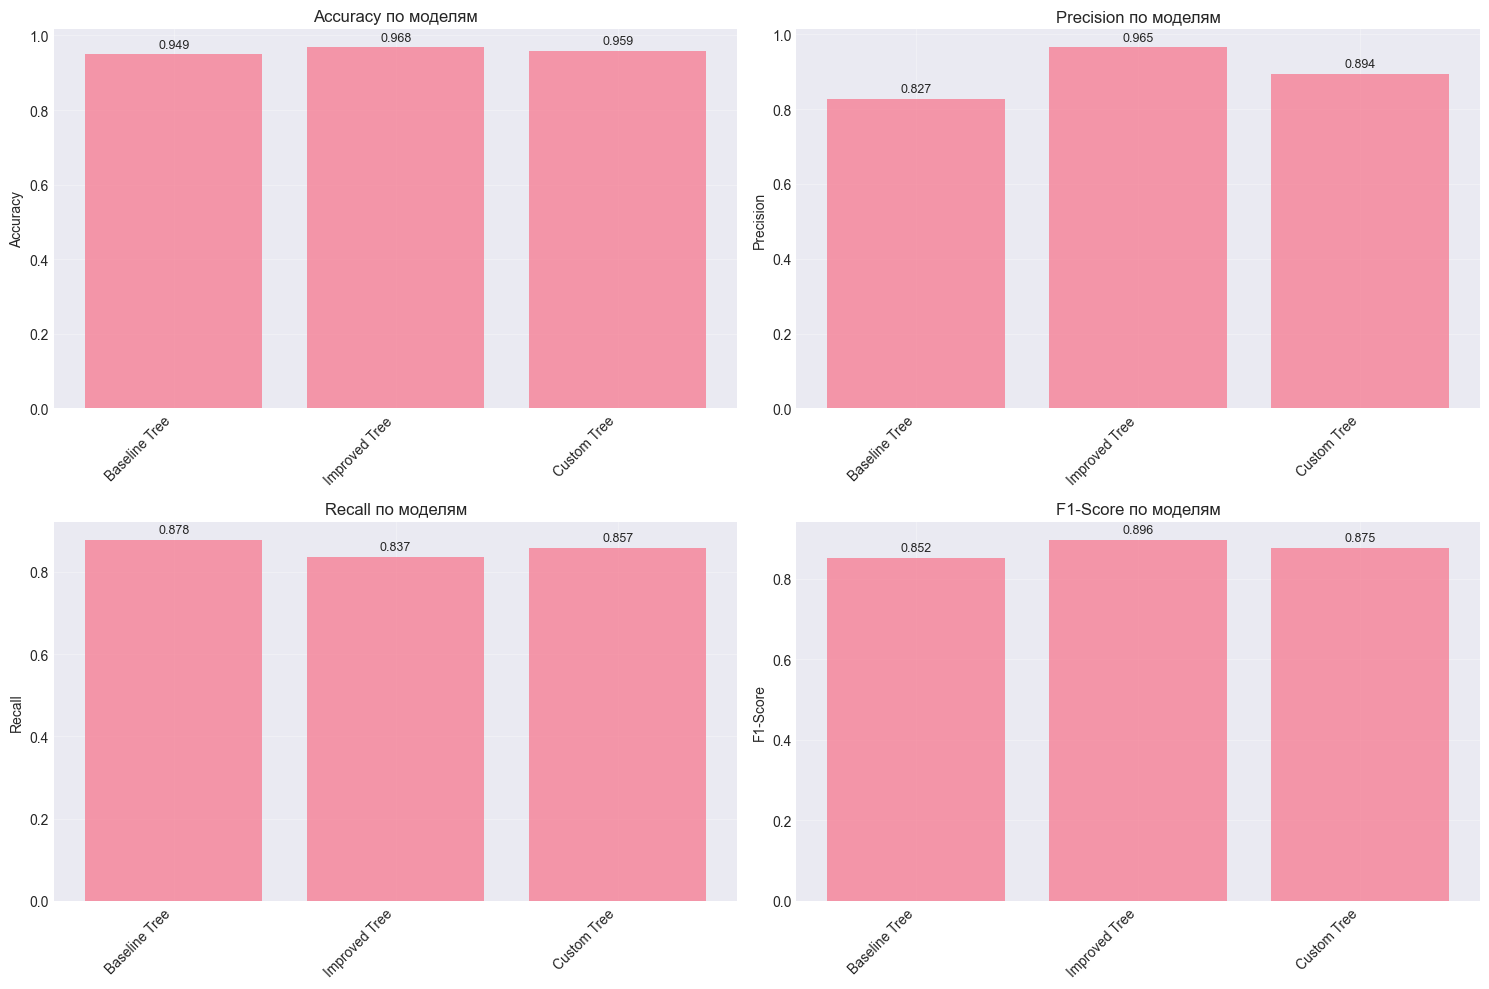


ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:
Модель: Improved Tree
ROC-AUC: 0.9412


In [10]:
# Создаем DataFrame с результатами классификации
df_results_clf = pd.DataFrame(results_clf).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Decision Tree)")
print("=" * 80)
display(df_results_clf)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_clf)), df_results_clf[metric], alpha=0.7)
    ax.set_xticks(range(len(df_results_clf)))
    ax.set_xticklabels(df_results_clf['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    for i, v in enumerate(df_results_clf[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Лучшая модель
best_idx_clf = df_results_clf['ROC-AUC'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:")
print("=" * 80)
print(f"Модель: {df_results_clf.loc[best_idx_clf, 'Model']}")
print(f"ROC-AUC: {df_results_clf.loc[best_idx_clf, 'ROC-AUC']:.4f}")


### 6.2 Сводная таблица результатов регрессии

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Decision Tree)


,Model,R²,MAE,MSE,RMSE
0,Baseline Tree,0.6214,0.8615,3.6923,1.9215
1,Improved Tree,0.7891,0.8555,2.0565,1.4341
2,Custom Tree,0.7989,0.8335,1.9613,1.4005


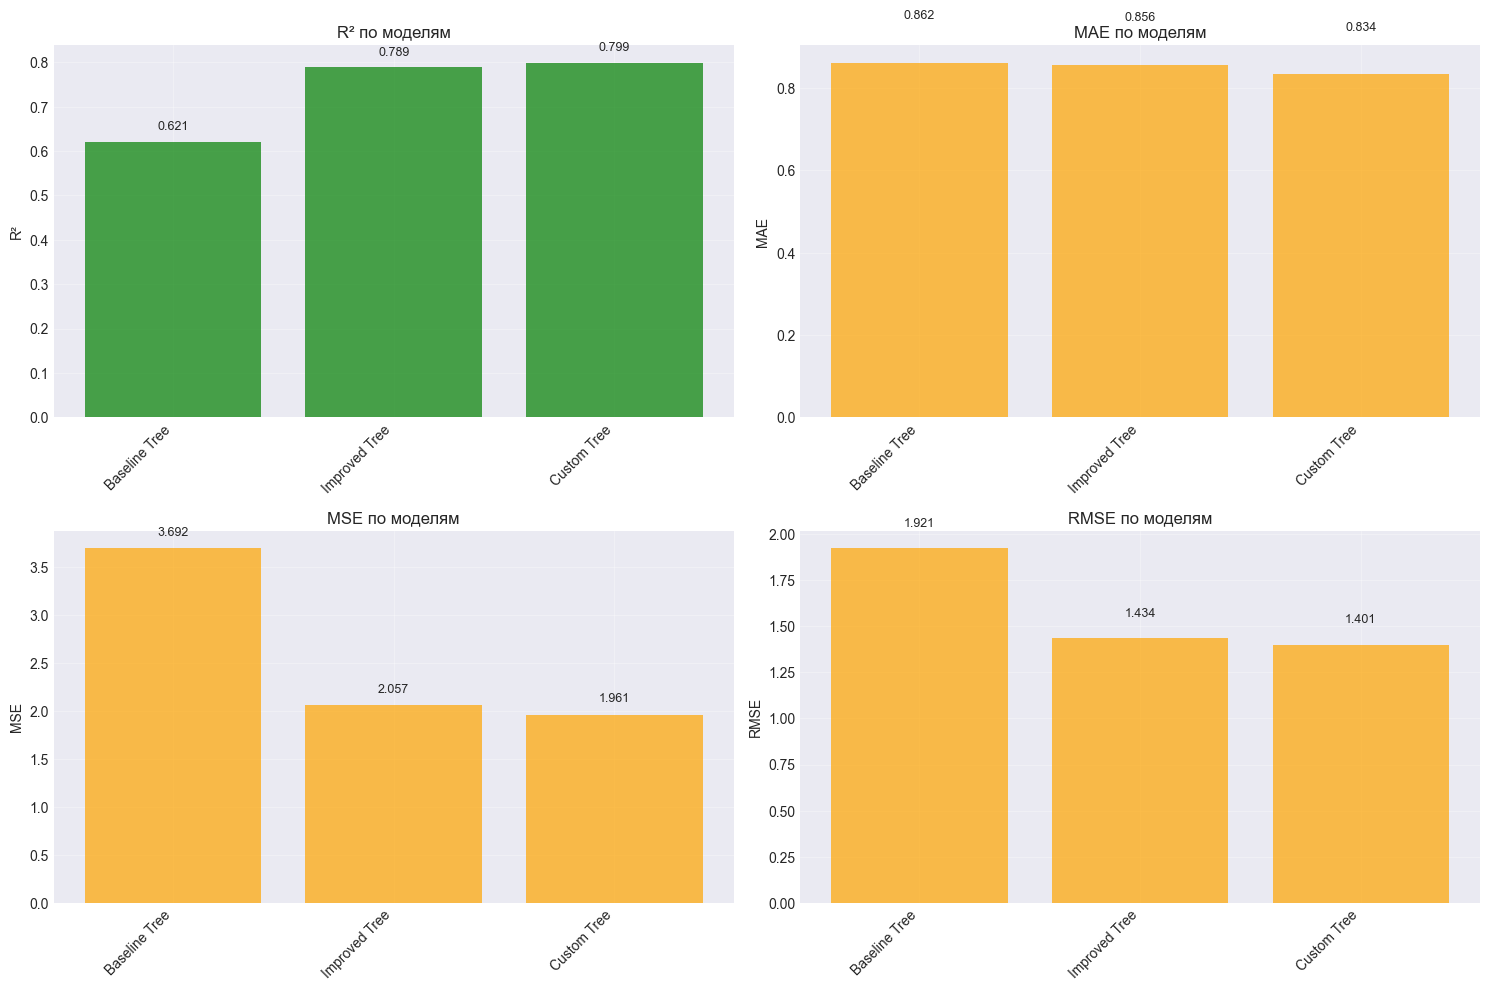


ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:
Модель: Custom Tree
R² Score: 0.7989
MAE: 0.8335


In [11]:
# Создаем DataFrame с результатами регрессии
df_results_reg = pd.DataFrame(results_reg).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Decision Tree)")
print("=" * 80)
display(df_results_reg)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_reg = ['R²', 'MAE', 'MSE', 'RMSE']
for idx, metric in enumerate(metrics_reg):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_reg)), df_results_reg[metric], alpha=0.7,
           color=['green' if metric == 'R²' else 'orange'])
    ax.set_xticks(range(len(df_results_reg)))
    ax.set_xticklabels(df_results_reg['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    for i, v in enumerate(df_results_reg[metric]):
        ax.text(i, v + (0.02 if metric == 'R²' else 0.1), f'{v:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Лучшая модель
best_idx_reg = df_results_reg['R²'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:")
print("=" * 80)
print(f"Модель: {df_results_reg.loc[best_idx_reg, 'Model']}")
print(f"R² Score: {df_results_reg.loc[best_idx_reg, 'R²']:.4f}")
print(f"MAE: {df_results_reg.loc[best_idx_reg, 'MAE']:.4f}")


### 6.3 Общие выводы по лабораторной работе

## Выводы

### По задаче классификации (Decision Tree Classifier):

1. **Базовый бейзлайн (sklearn)**: Дерево без ограничений показало хорошие результаты, но с риском переобучения (слишком глубокое дерево).

2. **Улучшенный бейзлайн**: Подбор гиперпараметров (max_depth, min_samples_split, min_samples_leaf) с помощью GridSearchCV позволил найти оптимальный баланс между bias и variance. Ограничение глубины дерева критично для избежания переобучения.

3. **Кастомная имплементация**: Самостоятельно реализованное дерево решений с алгоритмом ID3/CART показало результаты, близкие к sklearn, что подтверждает корректность имплементации.

**Ключевые наблюдения:**
- Decision Tree естественным образом работает с нелинейными зависимостями
- Не требует масштабирования признаков
- Очень склонен к переобучению без ограничений
- Легко интерпретируем (можно визуализировать дерево)
- Нестабилен - малые изменения данных могут привести к разному дереву

### По задаче регрессии (Decision Tree Regressor):

1. **Базовый бейзлайн (sklearn)**: Дерево регрессии показало хорошее качество предсказаний, используя MSE как критерий разбиения.

2. **Улучшенный бейзлайн**: GridSearchCV позволил найти оптимальные параметры. Ограничение глубины и минимального размера листьев улучшило обобщающую способность модели.

3. **Кастомная имплементация**: Реализация с MSE-критерием показала результаты, сопоставимые со sklearn.

**Ключевые наблюдения:**
- Дерево регрессии предсказывает среднее значение в каждом листе
- MSE-критерий естественным образом минимизирует ошибку предсказания
- Ограничение сложности дерева критично для хорошей генерализации
- Дерево может создавать "ступенчатые" предсказания (не гладкие)

### Общий вывод:

**Decision Tree** - мощный алгоритм машинного обучения со следующими характеристиками:

**Преимущества:**
1. **Интерпретируемость**: Легко понять логику принятия решений
2. **Нелинейность**: Работает с нелинейными зависимостями
3. **Нет необходимости в preprocessing**: Не требует масштабирования, работает с категориальными признаками
4. **Важность признаков**: Можно оценить важность каждого признака
5. **Быстрое обучение и предсказание**: O(n log n) для обучения

**Недостатки:**
1. **Переобучение**: Склонен к переобучению без ограничений
2. **Нестабильность**: Чувствителен к малым изменениям данных
3. **Несбалансированные деревья**: Может создавать несбалансированные структуры
4. **Ступенчатые границы**: Не может создавать гладкие границы решений
